#### <h1><center> WebScraping </h1>
<h1><center> Anno Accademico 2022-2023 </h1>
<h1><center>  Docente: Laura Ricci </h1>
<h1><center>  Lezione 20 </h1>
<h1><center>  Scale Free Networks</h1> 
<h1><center>  Correzione Analisi DataSet Bitcoin </h1>
<h1><center> 4 Aprile 2023 </h1>

# Astrazione delle transazioni di Bitcoin: il DataSet

<center>
<img src="Figures/BitcoinTables.jpg" style="width:700px;height:600px;"/>

# Astrazione delle transazioni di Bitcoin: il dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as mat
import numpy as np

Transactions = pd.read_csv('DataSet/Transactions.csv', names=['tx_id', 'blk_id'])
Inputs = pd.read_csv('DataSet/Inputs.csv', names=['in_id', 'tx_id', 'sig_id', 'output_id'])
Outputs = pd.read_csv('DataSet/Outputs.csv', names=['output_id', 'tx_id', 'pk_id', 'value'])

Transactions


,tx_id,blk_id
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
216621,216622,100016
216622,216623,100016
216623,216624,100016
216624,216625,100016


* primo passo: osservazione del **DataSet**

* una sola transazione per blocco, nei primi blocchi del **DataSet**
   * si tratta di **Coinbase**
   * transazioni di ricompensa al miner che ha risolto la **Proof of Work**
   * probabilmente minate da **Nakamoto** stesso
* gli ultimi blocchi includono più transazioni
* numero ultima transazione >> numero dell'ultimo blocco
   * diverse blocchi contengono molte transazioni
   
* **nota bene**: lo stesso nome **output_id** come identificatore di un output e come riferimento in un campo input.
    * questo ci consentirà di effettuare il **merge** dei due dataset

# Astrazione delle transazioni di Bitcoin: il dataset

In [2]:
Inputs


,in_id,tx_id,sig_id,output_id
0,1,1,0,-1
1,2,2,0,-1
2,3,3,0,-1
3,4,4,0,-1
4,5,5,0,-1
...,...,...,...,...
292422,292423,216622,95854,258874
292423,292424,216623,161394,247315
292424,292425,216624,173913,263227
292425,292426,216625,174188,263611


* primo passo: osservazione del **DataSet**
* nelle prime righe l'**output_id** è sempre uguale  a **-1**
    * questo conferma che si tratta di transazioni **Coinbase**: non c'è un puntatore a una transazione precedente
    * i bitcoin sono stati creati dal sistema, non provengono da una transazione precedente
    * gli **in_id** corrispondono ai **tx_id**
        * un solo input dummy per ogni transazione, non significativo (non punta a un output precedente)
* nelle ultime righe: il numero di **in_id** > **tx_id**
    * esisteno transazioni con più di un input, molte transazioni con un solo input

# Astrazione delle transazioni di Bitcoin: il dataset

In [3]:
Outputs


,output_id,tx_id,pk_id,value
0,1,1,1,5000000000
1,2,2,2,5000000000
2,3,3,3,5000000000
3,4,4,4,5000000000
4,5,5,5,5000000000
...,...,...,...,...
264305,264306,216623,174700,1000000
264306,264307,216623,174701,299000000
264307,264308,216624,167815,1000000
264308,264309,216625,174695,1200000


* primo passo: osservazione del **DataSet**

* le prime transazioni contengono un solo output
  * l'output corrisponde alla ricompensa data ai miners
  * inizialmente era di 5000000000 Satoshi = 50 BTC, poi dimezzata ogni 4 anni
* nelle ultime righe il numero di **output_id** > **tx_id**
  * esistono transazioni con output multipli
  * ad esempio la transazione <code> 216623 </code>  ha due output diversi

# Analisi delle transazioni: calcolo delle fee

* calcolare la distribuzione delle fee spese in ogni transazione nell'intero periodo contenuto nel **DataSet**
    * considerare tutte le transzioni, a parte le **CoinBase**
* calcolo delle fees per ogni transazione
   <center>
    $ \sum (input) - \sum (output)$
    </center>
    
  dove **input** e **output** sono i valori in input e output della transazione
* calcoliamo la somma dei **valori in input** e quella dei **valori in output** separatamente
    * somma dei valori in output di una transazione
        * <code> group_by </code> su <code> Output </code> in base a <code> tx_id </code>
    * somma dei valori in input di una transazione
        * i valori in input di una transazione sono contenuti nel precedente **UTXO**
        * occorre fare un merge tra <code> Input </code> e <code> Output </code> su <code> output_id </code> 
        * attenzione a non confondere i <code> tx_id </code> in  <code> Output </code> e quello in <code> Input </code> quando si fa la merge!
            * per il calcolo delle fee, interessa <code> tx_id </code>  di  <code> Input </code>!


# Analisi delle transazioni: calcolo valore in output di ogni transazione

In [63]:
# elimino la colonna relativa allo script di firma, inutile

Out=Outputs.drop(['pk_id'], axis="columns")

# raggruppo gli output per transazione 
# ogni gruppo comprende gli output di una transazione
# aggrego, sommando per calcolare la somma degli output uscenti di ogni transazione

OutTrans = Out.groupby('tx_id')['value'].sum().reset_index()  
OutTrans



,tx_id,value
0,1,5000000000
1,2,5000000000
2,3,5000000000
3,4,5000000000
4,5,5000000000
...,...,...
216621,216622,5000000000
216622,216623,300000000
216623,216624,1000000
216624,216625,1200000


* il campo **pk_id** non è utile per questa analisi, riguarda lo script per la verifica della firma
    * eliminiamo la colonna corrispondente dal **DataSet**
* **drop** rimuove una colonna o una riga specifica
    * **axis** specifica se si vuole eliminare una colonna o una riga
        * **axis="columns"** - colonna
        * **axis="index"** - riga
    * la colonna viene eliminata nel nuovo dataset creato, non in quello originale


# Analisi delle transazioni: calcolo valore in input di ogni transazione

* il problema della determinazione dei valori in input è più complesso, perchè
    * il valore di un input di una transazione si trova in un **Unspent Transaction Output (UTXO)** di una transazione precedente
    * <code> group_by </code> non è sufficiente,  ora serve collegare due diverse transazioni, quella che genera l'**UTXO**, e quella che lo spende
        * si utilizza una <code> merge </code>
    

In [5]:
Inp = Inputs.drop(['sig_id'] , axis=1)
Out = Outputs.drop(['tx_id', 'pk_id'], axis=1)
InpValues = pd.merge(Inp, Out, on='output_id')
InpValues


,in_id,tx_id,output_id,value
0,172,172,10,5000000000
1,184,184,173,4000000000
2,186,186,186,3000000000
3,188,188,189,2900000000
4,193,193,191,100000000
...,...,...,...,...
192403,292419,216618,264284,13836000000
192404,292423,216622,258874,5000000000
192405,292424,216623,247315,300000000
192406,292425,216624,263227,1000000


* drop: elimina i campi non importanti per questa analisi
    * nota bene: si elimina **tx_id** dal DataSet degli **Output**, perchè non interessa l'indice della transazione che produce l'**UTXO**, ma di quella che consuma gli output della transazione precednete
* merge
    * come una **inner join** sui due **DataFrame**
    * combina le righe con valore comune dell'attributo **output_id**
    * ogni input viene collegato all'output di una transazione precedente, di cui spende il valore
* analizziamo la riga <code> 192403 </code>
```
292419 216618 264284 13836000000
```

    * la transazione <code> 216618 </code>ha un input di indice <code> 292419</code>  che "consuma un output precedente" di indice <code> 264284</code>  di valore <code> 13836000000</code> . 
    * non interessa l'indice della transazione precedente, solo il valore in output che viene speso nell'input della transazione <code> 216618</code> 


# Analisi delle transazioni: Coinbase

* la procedura precedente non considera le **Coinbase**
* cosa è una **Coinbase**?
    * la prima transazione in ogni blocco della blockchain
    * utilizzata per inviare la ricompensa al miner che ha minato quel blocco
* il formato è lo stesso delle altre transazioni eccetto che
    * ha esattamente un input
    * quell'input non punta ad un **UXTO** precedente e non contiene un dato significativo
    * può contenere messaggia arbitrari
        * il messaggio di **Nakamoto** nella prima Coinbase: *“The Times 03/Jan/2009 Chancellor on brink of second bailout for banks"*
    * non ha fee, perchè le transazioni sono inserite nel blocco dal moner stesso
* gli output della transazione
    * possono essere in numero arbitrario
    * uno o più indirizzi del miner
    * la somma dei valori in output non può superare la somma della ricompensa data al miner con le fee di tutte le transazioni di quel blocco.


# Analisi delle transazioni: Coinbase

* Nel nostro DataSet
    * le **Coinbase** sono  transazioni che contengono un solo input
    * quell'input ha valore **-1**
    * il <code> sig_id </code> vale **0**
* le coinbase non sono incluse nel risultato del <code> merge </code>, perchè non c'è corrispondenza con un precedente <code> output_id </code>
* verifichiamolo!

In [6]:
print(InpValues.loc[InpValues["output_id"]==-1])

Empty DataFrame
Columns: [in_id, tx_id, output_id, value]
Index: []


# Analisi delle transazioni: calcolo valore in input di ogni transazione

In [7]:
InpValues.rename(columns={'in_id':'in_id', 'tx_id':'tx_id' , 'output_id':'utxo_id' , 'value':'value_to_be_spent'}, inplace=True)
InpTrans = InpValues.groupby('tx_id')['value_to_be_spent'].sum().reset_index()
InpTrans


,tx_id,value_to_be_spent
0,172,5000000000
1,184,4000000000
2,186,3000000000
3,188,2900000000
4,193,100000000
...,...,...
116602,216618,13836000000
116603,216622,5000000000
116604,216623,300000000
116605,216624,1000000


# Analisi delle transazioni: calcolo delle fee

In [8]:
#raggruppo per indice della transazione 
#unisco i Dataframe per avere, per ogni transazione, il valore speso e il valore uscente

Tx = pd.merge(InpTrans, OutTrans, on='tx_id') 

#aggiungo la colonna delle fees

Tx['fees'] = Tx['value_to_be_spent'] - Tx['value'] 

TxGreter0 = Tx.loc[Tx['fees'] > 0].sort_values('fees')
TxLessEq0 = Tx.loc[Tx['fees'] == 0]
TxLessLess0 = Tx.loc[Tx['fees'] < 0].sort_values('fees')

TxGreter0 , TxLessEq0, TxLessLess0


(        tx_id  value_to_be_spent         value         fees
 41817  125582            1000010       1000000           10
 31891  108835         3994999940    3994999930           10
 32671  110276         5001999850    5001999840           10
 31902  108848         3993999930    3993999920           10
 31906  108861         3992999920    3992999910           10
 ...       ...                ...           ...          ...
 5090    60913         5000000000    4665000000    335000000
 28386  101662       900432000000  900000000000    432000000
 22463   92976         5000000000         29000   4999971000
 27990  100849        20003971000   15004000000   4999971000
 30230  105281         5000000000   -5000000000  10000000000
 
 [1301 rows x 4 columns],
          tx_id  value_to_be_spent        value  fees
 0          172         5000000000   5000000000     0
 1          184         4000000000   4000000000     0
 2          186         3000000000   3000000000     0
 3          188         

* esiste una transazione con fee negativa: un errore nel Dataset

         tx_id  value_to_be_spent        value     fees
0          172         5000000000   5000000000        0
1          184         4000000000   4000000000        0
2          186         3000000000   3000000000        0
3          188         2900000000   2900000000        0
4          193          100000000    100000000        0
...        ...                ...          ...      ...
116602  216618        13836000000  13836000000        0
116603  216622         5000000000   5000000000        0
116604  216623          300000000    300000000        0
116605  216624            1000000      1000000        0
116606  216625            5000000      1200000  3800000

[116606 rows x 4 columns]


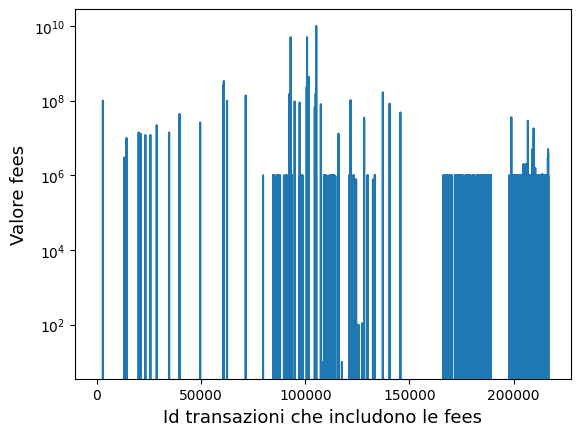

In [65]:
#plotting della distribuzione delle fees con valore maggiore di 0
Tx_Correct=Tx.loc[Tx['fees']>=0]
print(Tx_Correct)
X = list(Tx_Correct['tx_id'])
mat.plot(X,Tx_Correct['fees'])
mat.xlabel('Id transazioni che includono le fees', fontsize=13)
mat.ylabel('Valore fees', fontsize=13)
mat.yscale('log')
mat.show()


# Modelli di reti: Scale Free Networks

* esistono diverse reti 
    * reti sociali
    * reti tecnologiche, come Internet
    * reti ecologiche (preda-predatore, proteine,...)
* che sono caratterizzate da
    * small world 
    * high clustering
    * con una distribuzione dei gradi dei nodi che segue una legge **power law**
* reti con queste distribuzioni dei nodi vengono dette **scale free networks**
* i modelli visti fino ad ora (**Erdos Renyi** e **Watts Strogatz**) non sono adatti per descrivere questa distribuzione dei nodi
* nelle slide successive vedremo
    * cosa è una distribuzione **power law**
    * un nuovo modello, quello di **Barabasi Albert**, in grado di generare reti **scale free**


# Modelli di Reti sociali

* in una lezione precedente abbiamo introdotto i modelli di **Erdos Renyi(ER)** e quello di **Watts e Strogatz (WS)**

* **WS**
    * modella la caratteristica  **small world** di molte reti sociali
    * è il modello giusto per modellare tutte le caratteristiche di una rete sociale?

* analizziamo il sottoinsieme di **Facebook** che abbiamo introdotto in una lezione precedente   

* vedremo che **WS** riesce a cogliere la caratteristica di **Small World** della rete sociale, ma  non riesce a modellare in modo appropriato la distribuzione dei gradi dei nodi

* in particolare nella rete sociale        
    * esiste una grande variabilità nei gradi dei nodi, non presente nelle reti generate da **WS**
        
* necessario introdurre un nuovo modello 
    * **Barabasi Albert Model (BA)**

# Il dataset di Facebook

* utilizziamo il dataset di **Facebook**
    * solo le **relazioni di amicizia**
* ricordiamo che
    * il grafo delle amicizie è  ricavato da una rete di amicizie più grande
    * sono stati considerati alcuni nodi iniziali e sono state considerate le **ego networks**
    * la rete comprende la ego network di ognuno di questi nodi
        * il nodo, i suoi amici e le relazioni di amicizia tra i suoi amici
    * le ego networks sono state poi combinate
    * il grafo risultante contiene un sottoinsieme di Facebook
* a differenza del DataSet considerato nella lezione precedente
    * i dati sono memorizzati in un **file di testo** e non in un **file csv** 
        * valori separati da uno spazio bianco
        * questo tipo di file viene indicato in genere come **edgelist**
    * l'identificatore di ogni nodo è un intero (gli identificatori sono stati parsati per rendere più facile l'elaborazione)

# Il Dataset di Facebook

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
pd.read_csv('DataSet/facebook_combined.txt.gz', names=['FriendShipRelation'] )


,FriendShipRelation
0,0 1
1,0 2
2,0 3
3,0 4
4,0 5
...,...
88229,4026 4030
88230,4027 4031
88231,4027 4032
88232,4027 4038


* leggiamo il file come fosse un **csv**
* identificatori di una coppia di amici considerata un solo valore
    * non corretto: è necessario separare gli identificatori dei due amici!
* usiamo un diverso metodo di acquisizione dei dati

# Il Dataset di Facebook

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns 

# Impostiamo il seed random in modo che la funzione random produce tutte le volte lo stesso risultato
np.random.seed(17)

def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    print("shape of data:",array.shape)
    print("datatype of data:",array.dtype)
    G.add_edges_from(array)
    return G


In [67]:
fb= read_graph('DataSet/facebook_combined.txt.gz')

n = len(fb)
m = len(fb.edges())
n, m


shape of data: (88234, 2)
datatype of data: int32


(4039, 88234)

<code>  array = np.loadtxt(filename, dtype=int) </code>
  * utilizzata principalmente per leggere e scrivere **arrays** o **matrici** da **file di testo**
  * se non indicato, il delimitatore per separare i dati è lo spazio bianco
      * unica restrizione: ogni riga deve avere lo stesso numero di elementi
  * <code> dtype </code> indica il tipo dei dati dell'array risultato
  * restituisce un array n-dimensionale di <code> NumPy</code>
      * nel nostro caso, poichè ogni riga contiene due valori l'array ha **4039** righe e **due** colonne
     
<code>  G.add_edges_from(array) </code>
  * aggiunge un arco letto da un qualsasi **iterable container**
      

# Il Dataset di Facebook: analisi

* quale è il grado medio dei nodi?
* **m**= numero archi
* **n**= numero di nodi
* occorre poi considerare che ogni arco incide su due nodi

In [68]:
k = int(round(2*m/n))
k

44

* quale è il coefficente di clustering?
* utilizziamo un **approccio approssimato**,  diverso rispetto a quello della lezione precedente, per diminuire il tempo di esecuzione
    * **random sampling**
    * selezione casuale di un insieme di nodi e calcolo del coefficente di clustering per i nodi di questo insieme

In [69]:
from networkx.algorithms.approximation import average_clustering
C = average_clustering(fb)
C


0.599

# Il Dataset di Facebook: analisi

* adottiamo lo stesso approccio approssimato per calcolare la lunghezza media dei cammini

In [70]:
def sample_path_lengths(G, trials=1000):
    # Scelta random di un insieme di coppie di nodi e calcolo della lunghezza dei cammini tra le coppie
    # G: Graph
    # trials: numero delle coppie da cui scegliere
    # returns: lista di lunghezze dei cammini

    nodes = list(G)
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

def estimate_path_length(G, trials=1000):
    return np.mean(sample_path_lengths(G, trials))


In [71]:
L = estimate_path_length(fb)
L


3.648

* clustering coefficient alto, lunghezza media dei cammini bassi
* conferma che è una small world!

# Modellare Facebook con WS

* costruiamo un grafo di **WS** con caratteristiche analoghe al grafo di **Facebook**
* numero di nodi **n=4039**
* numero medio di vicini **k=44**
* probabilità di riavvolgere archi **p=0**

In [17]:
n=4039
k=44
lattice = nx.watts_strogatz_graph(n, k, p=0)
len(lattice), len(lattice.edges())


(4039, 88858)

In [72]:
C, average_clustering(lattice)


(0.599, 0.739)

* il clustering coefficient è un pò più alto di quello del DataSet reale, ma dello stesso ordine di grandezza

In [73]:
L, estimate_path_length(lattice)


(3.648, 46.064)

* la differenza tra le lunghezze medie dei cammini è enorme
* il risultato è atteso perchè impostando **p=0**, non abbiamo aggiunto alcun elemento di casualità

# Modellare Facebook con WS

* numero di nodi **n=4039**
* numero medio di vicini **k=44**
* probabilità di riavvolgere archi **p=1**

In [21]:
random_graph = nx.watts_strogatz_graph(n, k, 1)
C, average_clustering(random_graph)


(0.597, 0.006)

In [22]:
L, estimate_path_length(random_graph)

(3.717, 2.579)

* la lunghezza dei cammini è abbastanza confrontabile
* il coefficente di clustering è troppo basso!

# Modellare Facebook con WS

* numero di nodi **n=4039**
* numero medio di vicini **k=44**
* probabilità di riavvolgere archi **p=0.05**

In [74]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)
C, average_clustering(ws)


(0.599, 0.627)

In [75]:
L, estimate_path_length(ws)


(3.648, 3.208)

* valori paragonabili di clustering coefficient e lunghezza media dei cammini
* in questo caso **WS** modella perfettamente la caratteristica di **small world** del dataset reale!

# Facebook e Watts Strogatz: grado dei nodi

* studiamo ora la distribuzione dei gradi dei nodi
* utilizziamo la libreria <code> empiricaldist </code>
    * fornisce la funzione **Pmf (Probability Mass Function)**
    * restitusice una **Pandas Series** che rappresenta la distribuzione di probabilità dei valori in input
    * ad esempio

In [76]:
from empiricaldist import Pmf
d6 = Pmf.from_seq([1,2,3,4,5,6])
d6


,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


# Facebook e Watts Strogatz: grado dei nodi

* analizziamo grado medio e varianza dei nodi di **Facebook** e della rete **WS** e confrontiamole


In [77]:
def degrees(G):
    return [G.degree(u) for u in G]

np.mean(degrees(fb)), np.mean(degrees(ws))


(43.69101262688784, 44.0)

In [78]:
np.std(degrees(fb)), np.std(degrees(ws))


(52.41411556737521, 1.4309215628189869)

* utilizzo delle funzioni <code>mean</code> e <code>std</code> di <code>numpy</code>
    * applicate, per default,  a strutture <code>array</code> di <code>numpy</code>
    * se viene passata un'altra struttura compatibile (nel nostro caso una lista), si effettua la conversione

**Osservazione importante**

* la media dei gradi dei nodi del modello si avvicina molto alla media del grado dei nodi del Data Set
* ma la **varianza è molto diversa**!
* la varianza è molto alta per **Facebook**
    * alcuni hanno tantissimi amici, altri molto pochi
* non è altrettanto alta per **WS**

# Facebook e Watts Strogatz: grado dei nodi

* analizziamo e visualizziamo la **distribuzione** del grado dei nodi per **Facebook** e **WS** e confrontiamoli

In [79]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist
    

* un modulo può essere installato direttamente dallo script **Python**

In [81]:
pmf_fb = Pmf.from_seq(degrees(fb))

pmf_fb.mean(), pmf_fb.std()


(43.69101262688785, 52.41411556737521)

In [30]:
pmf_ws = Pmf.from_seq(degrees(ws))
pmf_ws.mean(), pmf_ws.std()

(44.00000000000001, 1.4309215628189869)

# Facebook e Watts Strogats: grado dei nodi

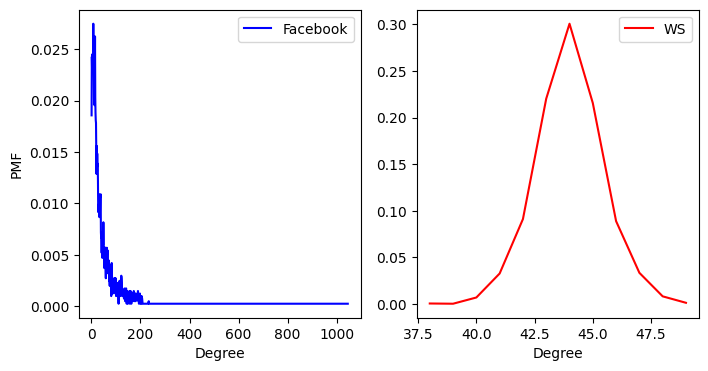

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(pmf_fb,'b',label="Facebook")
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.plot(pmf_ws,'r',label="WS")
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()


* in **WS** la maggior parte dei nodi ha grado **44**
    * classica  distribuzione **a campana**
* nel dataset di Facebook ci sono molto nodi di utenti con 1 o 2 amici, ma ci sono anche nodi che hanno più di 1000 amici!
    * distribuzioni come questa, con molti valori piccoli e pochi valori grandi vendono dette **heavy-tailed** o **power law**

# Power Law Distribution

* una distribuzione di probabilità definita come segue

<center>
$ PMF(k) \sim k^{-\alpha} $
</center>

viene detta **Power law** 
* $\alpha$ è un parametro: in genere vale $2$ oppure $3$
* nel nostro caso, $PMF(k)$ è la frazione dei nodi di grado k
* $\sim$ indica che la $PFM$ si avvicina asintoticamente a $k^{-\alpha}$, al crescere di $k$

* la probabilità di un certo valore $k$ decresce, ma non **esponenzialmente**

* altri esempi
    * distribuzione delle popolazione delle città USA
        * la maggior parte delle città ha pochi abitanti, ma ci sono poche città con un gran numero di abitanti
    * tutte le città con un gran numero di abitanti hanno un numero diverso di abitanti
    * la probabilità di avere città con **100** abitanti è grande
    * la probabilità  doi avere una città con **1000000** è bassa, ma non nulla


# Power Law Distribution su scala logaritmica

* una power law è rappresentata come una linea in **log-log scale**
    * scala logaritmica sia sull'asse delle x che sull'asse delle y

* consideriamo la seguente **power law**
    <center>
    $ y = C \times k^{-\alpha} $
    </center>

* calcoliamo il logaritmo sia della parte destra che della parte sinistra 

    <center>
    $ log(y) = {-\alpha} \times log(k) +  log(C)  $
    </center>

* ponendo 
    * $ Y= log(y) $
    * $X = log(k)$
    * $m=-\alpha$
    * $q=log(C)$
* si ottine la retta seguente il cui coefficente angolare dipende da $\alpha$
 <center>
   $Y=mX+q$
 </center>


# Power Law Distribution: esempi

<center>
<img src="Figures/PowerLaw1.jpg" style="width:800px;height:600px;"/>

# Power Law Distribution: esempi

<center>
<img src="Figures/PowerLaw2.jpg" style="width:800px;height:600px;"/>

# Modellare Facebook con Watts Strogatz: grado dei nodi

* disegnamo il grafico precedente in scala <code> log log </code> 

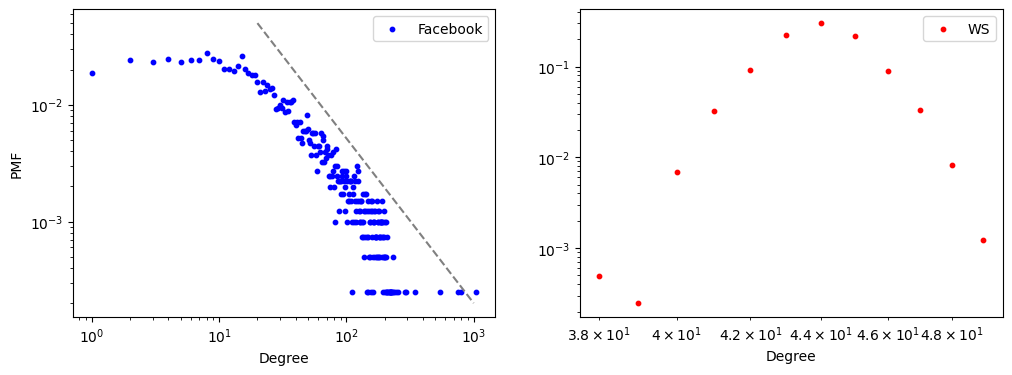

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')
plt.scatter(pmf_fb.index, pmf_fb,color='b',s=10, label="Facebook")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.scatter(pmf_ws.index,pmf_ws,color='r',s=10, label="WS")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()


* la rappresentazione <code> log log </code> evidenzia **la coda della distribuzione**
    * ci sono molti nodi che hanno grado tra <code> 100 </code> e <code> 1000 </code>
    * tuttavia ognuno di questi nodi ha grado diverso
    * la probabilità del singolo valore dei gradi alti  è bassa
    * invece ci sono tantissimi nodi con lo stesso valore del grado, per valori bassi
* la retta rappresenta il fitting della distribuzione

# Il modello di Barabasi Albert (BA)

* nel 1999 **Barabasi and Albert** proposero un nuovo modello per descrivere la struttura di molte reti reali il cui grado può essere descritto come una **power law**

* elementi essenziali del modello
    * **Growth**: invece considerare un numero fisso di nodi, iniziare con un numero basso di nodi e poi aggiungere vertici incrementalmente
    * **Preferential Attachment**: quando viene creato un nuovo nodo, connetterlo con maggior probabilità ai nodi esistenti che hanno
        un alto grado
* il fenomeno viene anche descritto come **"the rich get richer"**
* le reti generate con questo modello vengono dette **scale free networks**


# Il modello di Barbasi Albert (BA)

* **NetworkX** fornisce una funzione per generare grafi **BA**

In [34]:
ba = nx.barabasi_albert_graph(4039, 22)

# BA e Facebook a confronto

i parametri
  * **n**: il numero di nodi che il grafo deve avere alla fine del processo incrementale
  * **k**: il numero di archi generati per connettere ogni nuovo nodo aggiunto a nodi già esistenti
    * l'aggiunta di un nodo viene fatta secondo la strategia **preferential attachment**
  * nel nostro caso si aggiunge un nodo e 22 archi a ogni round
    * 22 è il numero medio di archi per nodo, nel dataset di Facebook

In [83]:
def degrees(G):
    return [G.degree(u) for u in G]

np.mean(degrees(fb)), np.mean(degrees(ba))


(43.69101262688784, 43.76033671700916)

In [84]:
np.std(degrees(fb)), np.std(degrees(ba))


(52.41411556737521, 40.959886553763404)

In [85]:
pmf_ba = Pmf.from_seq(degrees(ba))
pmf_ba.mean(), pmf_ba.std()


(43.76033671700916, 40.959886553763404)

* BA descrive bene la distribuzione dei gradi dei nodi di Facebook

# BA e Facebook a confronto

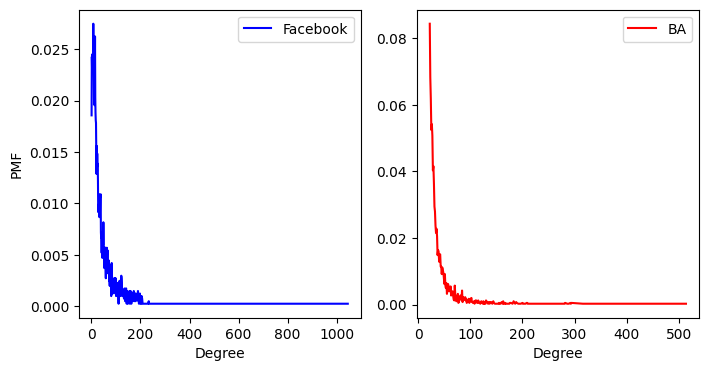

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(pmf_fb,'b',label="Facebook")
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.plot(pmf_ba,'r',label="BA")
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()


# BA e Facebook a confronto

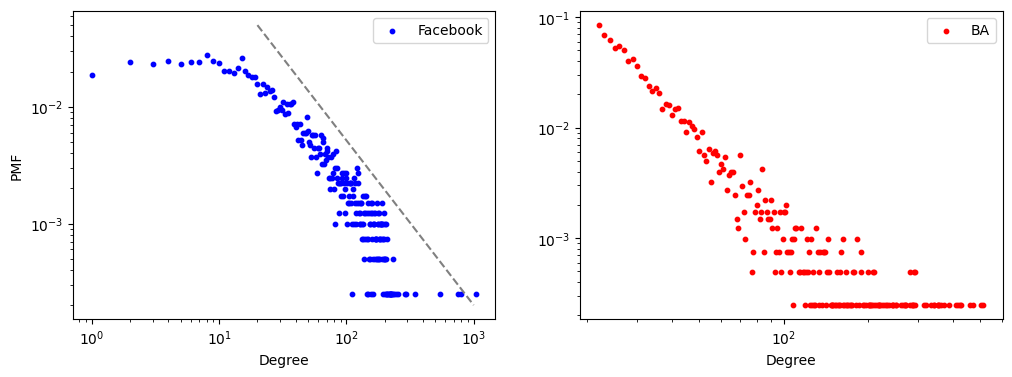

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')
plt.scatter(pmf_fb.index, pmf_fb,color='b',s=10, label="Facebook")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.scatter(pmf_ba.index,pmf_ba,color='r',s=10, label="BA")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.legend(loc="upper right")
plt.show()


# Algoritmo per la generazione dei grafi BA

<code>barabasi_albert_graph(4039, 22)</code>

* definiamo una funzione che operi come la funzione di **NetworkX**
* aggiungere incrementalmente nodi alla rete
    * ogni nuovo nodo è connesso a k nodi già esistenti nella rete
    * la probabilità di selezionare un nodo già esistente deve essere proporzionale al grado del nodo
        * mantenere una lista <code> repeated_nodes </code> in cui ogni nodo compare tante volte quanto è il suo grado
        * in questo modo, scegliendo in modo random unifome dalla lista, i nodi con grado maggiore hanno più probabilità
         die essere selezionati

<center>
<img src="Figures/Barabasi.jpg" style="width:500px;height:500px;"/>

# Alcune funzioni di utilità

* la funzione <code> zip </code> crea un iteratore aggregando elementi da più oggetti iterabili (liste,...)

In [60]:
numbers = [1, 2, 3]
letters = ['a', 'b', 'c']
zipped = zip(numbers, letters)
zipped  # Holds an iterator object
print(type(zipped))
list(zipped)

<class 'zip'>


[(1, 'a'), (2, 'b'), (3, 'c')]

* list replication

In [40]:
a = [1, 2, 3] 
d = a * 3 
d

[1, 2, 3, 1, 2, 3, 1, 2, 3]

In [41]:
a=[22]
b = a * 22
b

[22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22]

# Algoritmo per la generazione dei grafi BA

In [88]:
import random

def barabasi_albert_graph(n, k, seed=None):
    # costruisce un grafo di Barabasi ALbert
    # n: numero dei nodo
    # k: numero degli archi per ogni nodo
    # seed: random seed
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):
        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

# Algoritmo per la generazione dei grafi BA

In [92]:
def _random_subset(repeated_nodes, k):
    # seleziona un sottoinsieme random di nodi senza ripetizione
    # repeated_nodes: lista di nodi
    #  k: diemnsione dell'insieme
    # returns: insieme di nodi
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets


In [90]:
ba1=barabasi_albert_graph(4096,22)

np.mean(degrees(fb)), np.mean(degrees(ba1))


(43.69101262688784, 43.763671875)

In [91]:
np.std(degrees(fb)), np.std(degrees(ba1))


(52.41411556737521, 41.44139202821358)

# Perchè si chiamano scale free?

* le reti che hanno il grafo dei nodi descritti da una **power law** si chiamano **scale free**

* una funzione **F** viene detta **scale free** se

<center>
$f(bx) = C(b) * f(x)$
</center>   

*  C(b) è una costante che dipende solo da b
* la "forma" della distribuzione non cambia eccetto che per un valore moltiplicativo
* le funzione **power law** è **scale free**
    
<center>
$ f(bx)=(bx)^{-\alpha} = b^{-\alpha} x^{-\alpha} =  b^{-\alpha} f(x)$
</center>  
